In [1]:
import scanpy as sc
import numpy as np
import anndata

In [2]:
data_path = "project_folder/datasets/lincs_full_smiles_sciplex_genes.h5ad"
data = sc.read(data_path)

In [3]:
data.var

,pr_gene_title,pr_is_lm,pr_is_bing,gene_id,in_sciplex
DDR1,discoidin domain receptor tyrosine kinase 1,1,1,ENSG00000204580,True
PAX8,paired box 8,1,1,ENSG00000125618,True
RPS5,ribosomal protein S5,1,1,ENSG00000083845,True
ABCF1,ATP binding cassette subfamily F member 1,1,1,ENSG00000204574,True
SPAG7,sperm associated antigen 7,1,1,ENSG00000091640,True
...,...,...,...,...,...
PPARD,peroxisome proliferator activated receptor delta,1,1,ENSG00000112033,True
GNA11,guanine nucleotide binding protein (G protein)...,1,1,ENSG00000088256,True
WDTC1,WD and tetratricopeptide repeats 1,1,1,ENSG00000142784,True
PLSCR3,phospholipid scramblase 3,1,1,ENSG00000187838,True


In [4]:
control_indices =  np.where(data.obs["control"] == 1)[0].tolist()
test_indices = np.where(data.obs["random_split"] == "test")[0].tolist()
ood_indices =  np.where(data.obs["random_split"] == "ood")[0].tolist()

test_control = list(set(control_indices) & set(test_indices))

In [14]:
data[ood_indices].obs.cell_id.value_counts()

MCF7      8947
VCAP      8456
PC3       8255
A375      5290
HT29      5161
          ... 
SNUC4       44
SKLU1       44
MDST8       42
SKMEL1      39
HS27A        5
Name: cell_id, Length: 82, dtype: int64

In [6]:
pred_dict = dict(np.load("prediction_results.npz", allow_pickle=True))
print(pred_dict.keys())

dict_keys(['A375_AT1SHH09', 'A375_AT1SHH29', 'A375_AZD8330', 'A375_BRDK00640357', 'A375_BRDK55896799', 'A375_BRDK91338578', 'A375_BRDK93367411', 'A375_BRDK98948170', 'A375_COL3', 'A375_GDC0879', 'A375_GSK1059615', 'A375_GSK1070916', 'A375_KUC111109N', 'A375_KUC111774N', 'A375_MG132', 'A375_MK2206', 'A375_MLN8054', 'A375_MWSHH151', 'A375_MWSHH250', 'A375_MWSHH28', 'A375_MWSHH54', 'A375_MWSHH61', 'A375_MWSHH97', 'A375_MWSHH98', 'A375_PD0325901', 'A375_PHA793887', 'A375_SJBshh31', 'A375_STK721917', 'A375_WY01045', 'A375_amitriptyline', 'A375_amoxapine', 'A375_avicind', 'A375_betazole', 'A375_bortezomib', 'A375_canertinib', 'A375_chlorphenamine', 'A375_curcumin', 'A375_dabrafenib', 'A375_dasatinib', 'A375_dexamethasone', 'A375_diethylstilbestrol', 'A375_entinostat', 'A375_escitalopram', 'A375_estradiol', 'A375_estrone', 'A375_fluphenazine', 'A375_flutamide', 'A375_fulvestrant', 'A375_geldanamycin', 'A375_genistein', 'A375_homatropine', 'A375_imipramine', 'A375_manumycina', 'A375_mefenamica

In [7]:
max_smp = 0
max_cov_drug_key = ''
for cov_drug_key in pred_dict.keys():
    mean_pred, ture, mean_score, var_score, mean_score_de, var_score_de = pred_dict[cov_drug_key].item().values()
    if ture.shape[0] > max_smp:
        max_cov_drug_key = cov_drug_key
        max_smp = ture.shape[0]
max_cov_drug_key

'HELA_MG132'

In [8]:
cov_drug_key = 'HELA_MG132'
mean_pred, ture, mean_score, var_score, mean_score_de, var_score_de = pred_dict[cov_drug_key].item().values()

In [11]:
mean_pred.mean(axis=0).shape

(977,)

In [75]:
mean_pred.shape

(304, 977)

In [65]:
pred_adata = sc.AnnData(mean_pred, var=data.var) # from test control
true_adata = sc.AnnData(ture, var=data.var)
pred_adata.obs['condition'] = 'pred'
true_adata.obs['condition'] = 'true'
eval_adata = anndata.concat([pred_adata, true_adata])

/root/miniconda3/envs/chemCPA/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


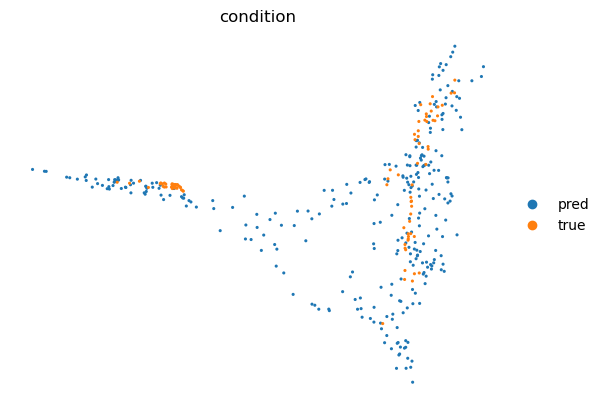

In [67]:
sc.pp.neighbors(eval_adata)
sc.tl.umap(eval_adata)
save_path = f"{cov_drug_key}_distribution.png"
sc.pl.umap(eval_adata, color=["condition"], wspace=0.4, frameon=False, 
           size=20, save=save_path)

In [ ]:
for cov_drug in pred_dict.keys():
    mean_pred, ture, _ = pred_dict[cov_drug]
    pred_adata = sc.AnnData(mean_pred, var=data.var)
    true_adata = sc.AnnData(mean_pred, var=data.var)